In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Set the GPU growth to avoid the event "Failed to get convolution algorithm"

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [6]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [7]:
# Free the conv_base before the training 
conv_base.trainable = False

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


train_dir = '/home/mike/Documents/keras_vgg16_tf2/cats_and_dogs_small/train'
validation_dir = '/home/mike/Documents/keras_vgg16_tf2/cats_and_dogs_small/validation'
test_dir = '/home/mike/Documents/keras_vgg16_tf2/cats_and_dogs_small/test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [10]:
# Compile the model 
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [11]:
# Start Tensorboard --logdir logs/fit
import datetime

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]

In [12]:
# Train the fintuned model
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=callback_list)

Epoch 1/30
100/100 [==============================] - 14s 136ms/step - loss: 0.5566 - acc: 0.7130 - val_loss: 0.3560 - val_acc: 0.8660
Epoch 2/30
100/100 [==============================] - 12s 118ms/step - loss: 0.3822 - acc: 0.8285 - val_loss: 0.2503 - val_acc: 0.9000
Epoch 3/30
100/100 [==============================] - 12s 117ms/step - loss: 0.3161 - acc: 0.8685 - val_loss: 0.2319 - val_acc: 0.9030
Epoch 4/30
100/100 [==============================] - 12s 117ms/step - loss: 0.2851 - acc: 0.8810 - val_loss: 0.2095 - val_acc: 0.9080
Epoch 5/30
100/100 [==============================] - 12s 118ms/step - loss: 0.2713 - acc: 0.8830 - val_loss: 0.1941 - val_acc: 0.9160
Epoch 6/30
100/100 [==============================] - 12s 118ms/step - loss: 0.2466 - acc: 0.8985 - val_loss: 0.1872 - val_acc: 0.9200
Epoch 7/30
100/100 [==============================] - 12s 117ms/step - loss: 0.2423 - acc: 0.9015 - val_loss: 0.1961 - val_acc: 0.9160
Epoch 8/30
100/100 [==============================] - 1

In [13]:
# Show the tensorboard in the Linux terminal 
%tensorboard --logdir logs/fit

In [14]:
model.save('/home/mike/Documents/keras_vgg16_tf2/cats_and_dogs_small_4.h5')

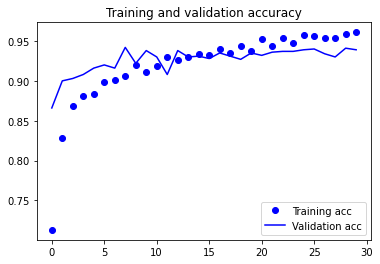

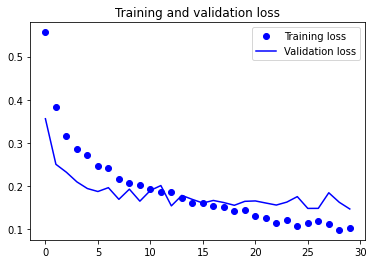

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

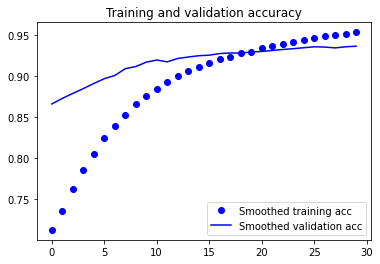

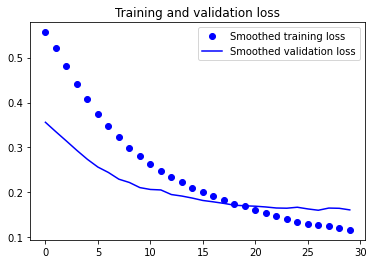

In [16]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9419999718666077


In [18]:
# Release the GPU Memory
from numba import cuda

cuda.select_device(0)
cuda.close()